In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

注意，基本上torch和numpy是可以实现相互转换的，但torch相比于numpy更加耗费资源，而numpy相比于torch缺少了部分结构（创建它的信息之类的与计算图有关的信息）

In [30]:
corpus = [
    'he is a king',
    'she is a queen',
    'she is a woman',
    'he is a man',
    'warsaw is poland capital',
    'berlin is germany capital',
    'paris is france capital',
]

# 构建共现矩阵

In [29]:
def construct_cocurrence_matrix(corpus):
    window_size = 2
    
    word2ind = {}
    ind2word = []
    cocurrence_matrix = None
    
    idx = 0
    vocabulary_size = 0
    for sentence in corpus:
        word_list = sentence.split()
        for word in word_list:
            if word not in word2ind:
                word2ind[word] = idx
                ind2word.append(word)
                idx += 1
    
    vocabulary_size = idx
    cocurrence_matrix = np.zeros((vocabulary_size, vocabulary_size))
    
    for sentence in corpus:
        word_list = sentence.split()
        for i in range(len(word_list)):
            center_pos = i
            left = max(0, i - window_size)
            right = min(len(word_list)-1, i + window_size)
            for j in range(left, right+1):
                if j != center_pos:
                    context_pos = j
                    center_word = word_list[center_pos]
                    context_word = word_list[context_pos]
                    center_indices = word2ind[center_word]
                    context_indices = word2ind[context_word]
                    cocurrence_matrix[center_indices][context_indices] += 1
                    
    return cocurrence_matrix, word2ind, ind2word, vocabulary_size

cocurrence_matrix, word2ind, ind2word, vocabulary_size = construct_cocurrence_matrix(corpus)
X = torch.from_numpy(cocurrence_matrix)
X += 1
X = X.float()

# Model
创建类的好处？

0. 把所有与这个类有关的行为放在一个地方描述
1. 可以和函数一样实现封装，即保证内部变量名不污染外部环境
2. 除了变量封装，还能实现函数封装，即保证内部函数名不污染外部环境
2. 可以实现接口，即继承自接口的类的实例能被其他与其配套的框架/库/工具识别，并自动调用/注册其中的方法，类似于plug-in的形式

In [4]:
class Glove(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        """
            __init__为其他方法创建环境，每个实例独有，实例的方法共享
        """
        super(Glove, self).__init__()
        self.W1 = torch.randn(num_embeddings, embedding_dim, requires_grad=True)
        self.W2 = torch.randn(num_embeddings, embedding_dim, requires_grad=True)
        self.b1 = torch.zeros(num_embeddings, requires_grad=True)
        self.b2 = torch.zeros(num_embeddings, requires_grad=True)
    
    def forward(self, i_indices, j_indices):
        vi = self.W1[i_indices]
        vj = self.W2[j_indices]
        return torch.dot(vi, vj) + self.b1[i_indices] + self.b2[j_indices]

k = 5
glove = Glove(vocabulary_size, k)

# Target && Loss

In [17]:
def wmse_loss(weights, inputs, targets):
    return weights * (inputs - targets) ** 2

In [16]:
def fX(x, xmax, alpha):
    wx = (x/xmax)**alpha
    return torch.min(wx, torch.ones_like(wx))

loss为nan，是因为有的X[i][j]为0

# Algorithm
注意此处parameter和optimizer的用法

In [31]:
NUM_EPOCHS = 100
X_MAX = 100
ALPHA = 0.75
X = torch.from_numpy(cocurrence_matrix)
loss_values = []
lr = 0.05
parameters = [glove.W1, glove.W2, glove.b1, glove.b2]
optimizer = optim.Adagrad(parameters, lr=0.05)

for epo in range(NUM_EPOCHS):
    for i in range(vocabulary_size):
        for j in range(vocabulary_size):
            outputs = glove(i, j)
            
            weights = fX(X[i][j], X_MAX, ALPHA)
            loss = wmse_loss(weights, outputs, torch.log(X[i][j]))
            loss.backward()
            
            optimizer.step()
            
            loss_values.append(loss.item())
            
    print ("Epoch {}/{} \t Loss: {}".format(epo, NUM_EPOCHS, np.mean(loss_values[-5:])))

Epoch 0/100 	 Loss: 27.45143538976191
Epoch 1/100 	 Loss: 6.787442711686888
Epoch 2/100 	 Loss: 4.131574350320049
Epoch 3/100 	 Loss: 2.6900749493057767
Epoch 4/100 	 Loss: 3.6112865791638713
Epoch 5/100 	 Loss: 7.548125914661945
Epoch 6/100 	 Loss: 7.826589343379898
Epoch 7/100 	 Loss: 4.724595339464822
Epoch 8/100 	 Loss: 4.613131069447366
Epoch 9/100 	 Loss: 8.288281412898261
Epoch 10/100 	 Loss: 8.830672328534245
Epoch 11/100 	 Loss: 5.323838644061658
Epoch 12/100 	 Loss: 5.0749009580261895
Epoch 13/100 	 Loss: 11.224934521575003
Epoch 14/100 	 Loss: 17.84459366035441
Epoch 15/100 	 Loss: 18.095419708843547
Epoch 16/100 	 Loss: 11.849040387257126
Epoch 17/100 	 Loss: 5.248747900756756
Epoch 18/100 	 Loss: 4.373965485132228
Epoch 19/100 	 Loss: 8.33141988950138
Epoch 20/100 	 Loss: 11.937103026826971
Epoch 21/100 	 Loss: 12.49887622668277
Epoch 22/100 	 Loss: 10.545919555404037
Epoch 23/100 	 Loss: 7.692361383533807
Epoch 24/100 	 Loss: 5.594900504901996
Epoch 25/100 	 Loss: 4.79993

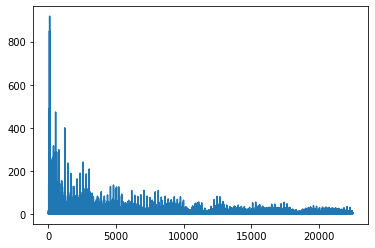

In [32]:
plt.plot(loss_values)